In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC,SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier , AdaBoostClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV
from svm_margin_plot import plot_svm_boundary
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix, accuracy_score

## Ensemble Classification

* Suppose you have trained a few classifiers, each one achieving about 80% accuracy.
You may have a Logistic Regression classifier, an SVM classifier, a Random Forest
classifier, a K-Nearest Neighbors classifier
* A very simple way to create an even better classifier is to aggregate the predictions of
### hard voting
* each classifier and predict the class that gets the most votes. This majority-vote classifier is called a hard voting classifier
* this is only true if all classifiers are perfectly independent, making uncorrelated errors, which is clearly not the case since they are trained on the same data

In [2]:
x,y = datasets.make_moons(n_samples=100, shuffle=True, noise=None, random_state=None)

In [3]:
x

array([[ 1.99179001e+00,  3.72122838e-01],
       [-9.81559157e-01,  1.91158629e-01],
       [-9.97945393e-01,  6.40702200e-02],
       [-8.01413622e-01,  5.98110530e-01],
       [ 4.62538290e-01,  8.86599306e-01],
       [ 1.67230089e+00, -2.40277997e-01],
       [ 5.18392568e-01,  8.55142763e-01],
       [-5.18392568e-01,  8.55142763e-01],
       [-4.62538290e-01,  8.86599306e-01],
       [-8.38088105e-01,  5.45534901e-01],
       [ 2.81650650e-01, -1.95682551e-01],
       [ 1.59599895e-01,  9.87181783e-01],
       [-1.00000000e+00,  1.22464680e-16],
       [ 1.15959990e+00, -4.87181783e-01],
       [ 1.46253829e+00, -3.86599306e-01],
       [ 8.01413622e-01,  5.98110530e-01],
       [ 7.18349350e-01,  6.95682551e-01],
       [-3.45365054e-01,  9.38468422e-01],
       [ 1.76144596e+00, -1.48228395e-01],
       [ 1.57211666e+00, -3.20172255e-01],
       [-4.04783343e-01,  9.14412623e-01],
       [ 4.81607432e-01, -3.55142763e-01],
       [-9.26916757e-01,  3.75267005e-01],
       [ 7.

In [4]:
y

array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1], dtype=int64)

In [5]:
df = pd.DataFrame(data=x,columns=['x1','x2'])
df['target'] = y
df.head()

,x1,x2,target
0,1.991790,0.372123,1
1,-0.981559,0.191159,0
2,-0.997945,0.064070,0
3,-0.801414,0.598111,0
4,0.462538,0.886599,0


<AxesSubplot:xlabel='x1', ylabel='x2'>

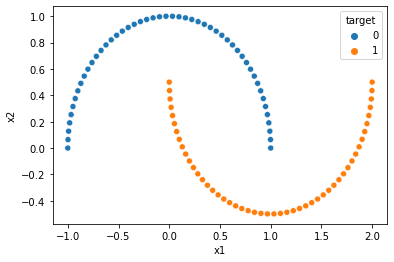

In [6]:
sns.scatterplot(x= 'x1',y='x2',hue='target',data=df)

In [7]:
X = df.drop('target',axis=1)
Y=df['target']

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=101)

In [9]:
# scaler= StandardScaler()
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_test)

In [10]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

In [11]:
voting_clf = VotingClassifier(estimators=[('lr',log_clf),('rf',rnd_clf),('svm',svm_clf)],voting='hard')

In [12]:
voting_clf.fit(x_train,y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svm', SVC())])

In [13]:
for clf in (log_clf,rnd_clf,svm_clf,voting_clf):
    clf.fit(x_train,y_train)
    y_preds = clf.predict(x_test)
    print(clf.__class__.__name__,accuracy_score(y_test,y_preds))

LogisticRegression 0.95
RandomForestClassifier 1.0
SVC 1.0
VotingClassifier 1.0


### soft voting
* If all classifiers are able to estimate class probabilities (i.e., they have a pre
dict_proba() method), then you can tell Scikit-Learn to predict the class with the
highest class probability, averaged over all the individual classifiers. This is called soft voting.
*  replace voting="hard" with voting="soft  and ensure that all classifiers can estimate class probabilities. 
* This is not the case of the SVC class by default, so you need to set its probability hyperparameter to True (this will make the SVC class use cross-validation to estimate class probabilities, slowing down training, and it will add a predict_proba() method).

In [14]:
svm_clf = SVC(probability=True)

In [15]:
soft_clf = VotingClassifier(estimators=[('lr',log_clf),('rf',rnd_clf),('svm',svm_clf)],voting='soft')

In [16]:
soft_clf.fit(x_train,y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()),
                             ('svm', SVC(probability=True))],
                 voting='soft')

In [17]:
for clf in (log_clf,rnd_clf,svm_clf,soft_clf):
    clf.fit(x_train,y_train)
    y_preds = clf.predict(x_test)
    print(clf.__class__.__name__,accuracy_score(y_test,y_preds))

LogisticRegression 0.95
RandomForestClassifier 1.0
SVC 1.0
VotingClassifier 1.0


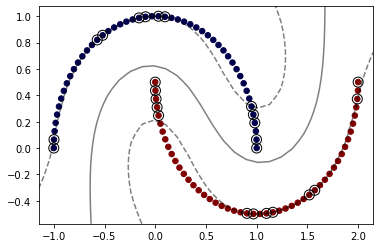

In [18]:
plot_svm_boundary(svm_clf,X,Y)

## Bagging and Pasting

* Sampling is performed **with replacement**, this method is called **bagging**(short for bootstrap aggregating2).
* Sampling is performed **without replacement**, it is called **pasting**.
* In other words, both bagging and pasting allow training instances to be sampled several times across multiple predictors, but only bagging allows training instances to be sampled several times for the same predictor.
* Once all predictors are trained, the ensemble can make a prediction for a new instance by simply aggregating the predictions of all predictors.
* The aggregation function is typically the statistical mode (i.e., the most frequent prediction, just like a hard voting classifier) for classification, or the average for regression.

In [19]:
# with replacement Bagging bootstrap=True 
bag_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=500,max_samples=50,bootstrap=True,n_jobs=-1)
bag_clf.fit(x_train,y_train)
y_pred = bag_clf.predict(x_test)

In [20]:
print(bag_clf.__class__.__name__,accuracy_score(y_test,y_preds))

BaggingClassifier 1.0


In [21]:
# without replacement Pasting bootstrap=False
past_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=500,max_samples=50,bootstrap=False,n_jobs=-1)
past_clf.fit(x_train,y_train)
y_pred = past_clf.predict(x_test)

In [22]:
print(past_clf.__class__.__name__,accuracy_score(y_test,y_preds))

BaggingClassifier 1.0


## Out of Bag Evaluation

In [23]:
# with replacement Bagging bootstrap=True 
bag_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=500,max_samples=50,bootstrap=True,oob_score=True,n_jobs=-1)
bag_clf.fit(x_train,y_train)
y_pred = bag_clf.predict(x_test)

In [24]:
print(bag_clf.__class__.__name__,accuracy_score(y_test,y_preds))

BaggingClassifier 1.0


In [25]:
bag_clf.oob_score_

0.925

In [26]:
 bag_clf.oob_decision_function_

array([[0.5035461 , 0.4964539 ],
       [0.29473684, 0.70526316],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.80842912, 0.19157088],
       [0.02966102, 0.97033898],
       [1.        , 0.        ],
       [0.996139  , 0.003861  ],
       [1.        , 0.        ],
       [0.53307393, 0.46692607],
       [0.01123596, 0.98876404],
       [0.        , 1.        ],
       [0.05970149, 0.94029851],
       [0.40377358, 0.59622642],
       [0.8996139 , 0.1003861 ],
       [0.99253731, 0.00746269],
       [0.75958188, 0.24041812],
       [1.        , 0.        ],
       [0.14574899, 0.85425101],
       [0.        , 1.        ],
       [0.10687023, 0.89312977],
       [0.75100402, 0.24899598],
       [0.87544484, 0.12455516],
       [0.92114695, 0.07885305],
       [0.        , 1.        ],
       [0.84870849, 0.15129151],
       [0.29527559, 0.70472441],
       [0.00696864, 0.99303136],
       [1.        , 0.        ],
       [0.83745583, 0.16254417],
       [0.

In [27]:
rnd_clf = RandomForestClassifier(n_estimators=500,max_leaf_nodes=16,n_jobs=-1)

In [28]:
rnd_clf.fit(x_train,y_train)

RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1)

In [29]:
y_preds = rnd_clf.predict(x_test)

In [30]:
print(rnd_clf.__class__.__name__,accuracy_score(y_test,y_preds))

RandomForestClassifier 1.0


In [31]:
errors = []
missclassification = []
for i in range(1,500):
    rnd_clf = RandomForestClassifier(n_estimators=i,max_features=2,n_jobs=-1)
    rnd_clf.fit(x_train,y_train)
    preds = rnd_clf.predict(x_test)
    errors.append(1-accuracy_score(y_test,preds))
    missclassification.append(np.sum(preds != y_test))

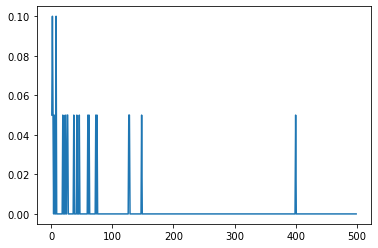

In [32]:
plt.plot(range(1,500),errors)

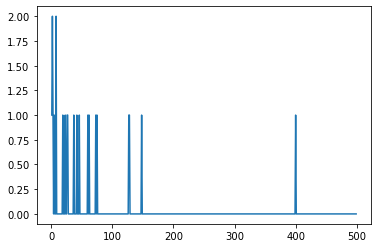

In [33]:
plt.plot(range(1,500),missclassification)

#### The following BaggingClassifier is roughly equivalent to the previous RandomForestClassifier
* The BaggingClassifier class remains useful if you want a bag of something other than Decision Trees

In [34]:
bag_clf = BaggingClassifier(base_estimator= DecisionTreeClassifier(splitter='random',max_leaf_nodes=16),n_estimators=500,
                            max_samples=1,bootstrap=True,n_jobs=-1)

In [35]:
bag_clf.fit(x_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_leaf_nodes=16,
                                                        splitter='random'),
                  max_samples=1, n_estimators=500, n_jobs=-1)

In [36]:
y_preds = bag_clf.predict(x_test)

In [37]:
print(bag_clf.__class__.__name__,accuracy_score(y_test,y_preds))

BaggingClassifier 0.45


In [38]:
bag_clf = BaggingClassifier(base_estimator= DecisionTreeClassifier(splitter='random',max_leaf_nodes=16),n_estimators=500,
                            max_samples=50,bootstrap=True,n_jobs=-1)

In [39]:
bag_clf.fit(x_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_leaf_nodes=16,
                                                        splitter='random'),
                  max_samples=50, n_estimators=500, n_jobs=-1)

In [40]:
y_preds = bag_clf.predict(x_test)

In [41]:
print(bag_clf.__class__.__name__,accuracy_score(y_test,y_preds))

BaggingClassifier 1.0


## Feature importance 

In [42]:
iris = datasets.load_iris()

In [43]:
rnd_clf = RandomForestClassifier(n_estimators=500,n_jobs=-1)

In [44]:
rnd_clf.fit(iris['data'],iris['target'])

RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [45]:
for name,score in zip(iris.feature_names,rnd_clf.feature_importances_):
    print(name,score)

sepal length (cm) 0.10384770889358616
sepal width (cm) 0.026506615905274377
petal length (cm) 0.4022959116595639
petal width (cm) 0.46734976354157554


# Boosting

# AdaBoost

Attribute Information: (classes: edible=e, poisonous=p)

cap-shape: bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s

cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s

cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y

bruises: bruises=t,no=f

odor: almond=a,anise=l,creosote=c,fishy=y,foul=f,musty=m,none=n,pungent=p,spicy=s

gill-attachment: attached=a,descending=d,free=f,notched=n

gill-spacing: close=c,crowded=w,distant=d

gill-size: broad=b,narrow=n

gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g, green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y

stalk-shape: enlarging=e,tapering=t

stalk-root: bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r,missing=?

stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s

stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s

stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y

stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y

veil-type: partial=p,universal=u

veil-color: brown=n,orange=o,white=w,yellow=y

ring-number: none=n,one=o,two=t

ring-type: cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z

spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y

population: abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y

habitat: grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d

In [46]:
mushrom = pd.read_csv("mushrooms.csv")

In [47]:
mushrom.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [48]:
mushrom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [49]:
feat_info = mushrom.describe(include=['O']).T.reset_index().sort_values('unique')
feat_info

,index,count,unique,top,freq
16,veil-type,8124,1,p,8124
0,class,8124,2,e,4208
4,bruises,8124,2,f,4748
6,gill-attachment,8124,2,f,7914
7,gill-spacing,8124,2,c,6812
8,gill-size,8124,2,b,5612
10,stalk-shape,8124,2,t,4608
18,ring-number,8124,3,o,7488
2,cap-surface,8124,4,y,3244
17,veil-color,8124,4,w,7924


<AxesSubplot:xlabel='unique', ylabel='index'>

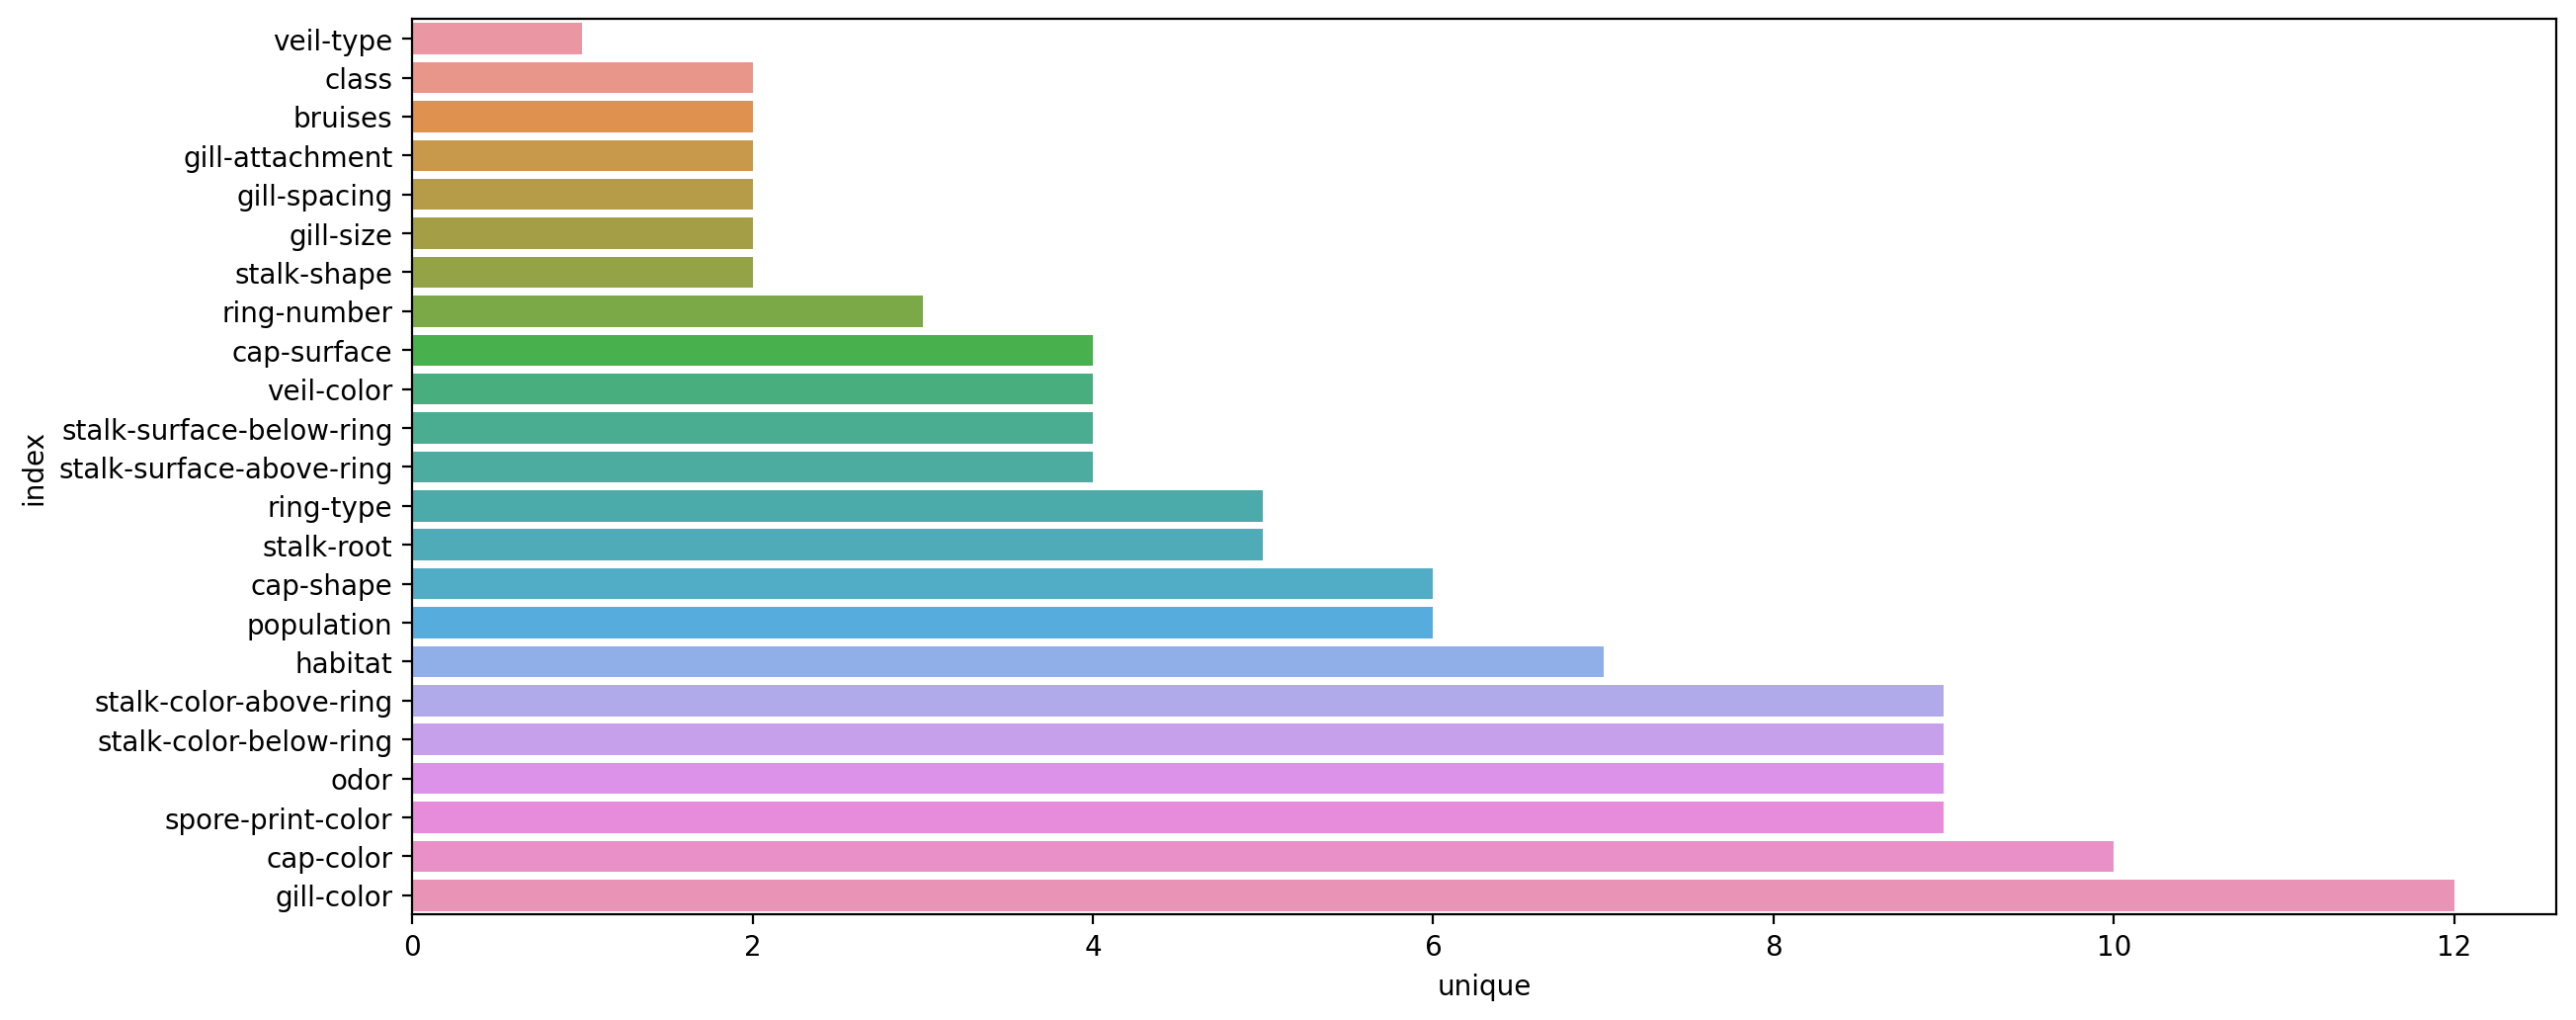

In [50]:
plt.figure(figsize=(14,6),dpi=200)
sns.barplot(data=feat_info,x='unique',y='index')

# check the class balance

<AxesSubplot:xlabel='class', ylabel='count'>

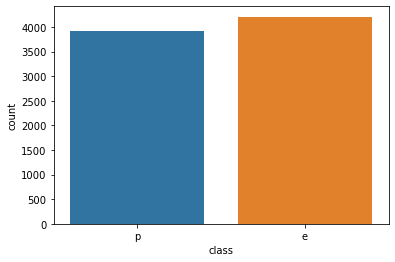

In [51]:
sns.countplot(data=mushrom,x='class')

In [52]:
mushrom.isnull().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

In [53]:
x = mushrom.drop('class',axis=1)
y = mushrom['class']

In [54]:
x = pd.get_dummies(x,drop_first=True)

In [55]:
x

,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_g,cap-surface_s,cap-surface_y,cap-color_c,cap-color_e,...,population_n,population_s,population_v,population_y,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,0,0,0,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
1,0,0,0,0,1,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,0,0,0,0,1,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
4,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8120,0,0,0,0,1,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0
8121,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8122,0,0,1,0,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0


In [56]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=101)

### AdaBoost classifier
* Can use any weak learner 'machine learning model' 
* A Decision Stump is a Decision Tree with max_depth=1—inother words, a tree composed of a single decision node plus two leaf nodes. This is the default base estimator for the AdaBoostClassifier class.

In [57]:
model = AdaBoostClassifier(n_estimators=1)

In [58]:
model.fit(x_train,y_train)
preds = model.predict(x_test)

In [59]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           e       0.96      0.81      0.88       655
           p       0.81      0.96      0.88       564

    accuracy                           0.88      1219
   macro avg       0.88      0.88      0.88      1219
weighted avg       0.89      0.88      0.88      1219



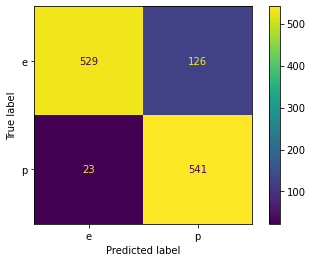

In [60]:
plot_confusion_matrix(model,x_test,y_test)

In [61]:
accuracy_score(y_test,preds)

0.8777686628383922

In [62]:
model.feature_importances_

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [63]:
# most importance feature index 
model.feature_importances_.argmax()

22

In [64]:
for name,score in zip(x.columns,model.feature_importances_):
        print(name,score)

cap-shape_c 0.0
cap-shape_f 0.0
cap-shape_k 0.0
cap-shape_s 0.0
cap-shape_x 0.0
cap-surface_g 0.0
cap-surface_s 0.0
cap-surface_y 0.0
cap-color_c 0.0
cap-color_e 0.0
cap-color_g 0.0
cap-color_n 0.0
cap-color_p 0.0
cap-color_r 0.0
cap-color_u 0.0
cap-color_w 0.0
cap-color_y 0.0
bruises_t 0.0
odor_c 0.0
odor_f 0.0
odor_l 0.0
odor_m 0.0
odor_n 1.0
odor_p 0.0
odor_s 0.0
odor_y 0.0
gill-attachment_f 0.0
gill-spacing_w 0.0
gill-size_n 0.0
gill-color_e 0.0
gill-color_g 0.0
gill-color_h 0.0
gill-color_k 0.0
gill-color_n 0.0
gill-color_o 0.0
gill-color_p 0.0
gill-color_r 0.0
gill-color_u 0.0
gill-color_w 0.0
gill-color_y 0.0
stalk-shape_t 0.0
stalk-root_b 0.0
stalk-root_c 0.0
stalk-root_e 0.0
stalk-root_r 0.0
stalk-surface-above-ring_k 0.0
stalk-surface-above-ring_s 0.0
stalk-surface-above-ring_y 0.0
stalk-surface-below-ring_k 0.0
stalk-surface-below-ring_s 0.0
stalk-surface-below-ring_y 0.0
stalk-color-above-ring_c 0.0
stalk-color-above-ring_e 0.0
stalk-color-above-ring_g 0.0
stalk-color-above

In [65]:
max_score=0
feat_most=None
for name,score in zip(x.columns,model.feature_importances_):
    if score > max_score:
        max_score = score
        feat_most = name
print(feat_most,max_score)

odor_n 1.0


In [66]:
print (x.columns[model.feature_importances_.argmax()])

odor_n


<AxesSubplot:xlabel='odor', ylabel='count'>

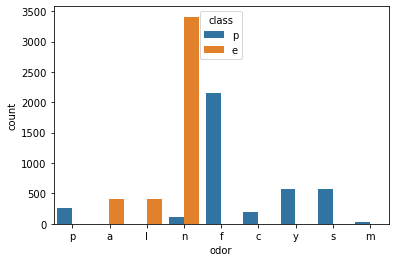

In [67]:
sns.countplot(data=mushrom,x='odor',hue='class')

In [68]:
error_rate = []
for i in range(1,96):
    model = AdaBoostClassifier(n_estimators=i)
    model.fit(x_train,y_train)
    preds = model.predict(x_test)
    error_rate.append(1-(accuracy_score(y_test,preds)))

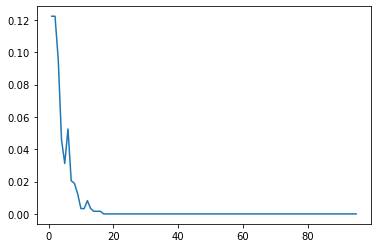

In [69]:
plt.plot(range(1,96),error_rate)

In [70]:
model = AdaBoostClassifier(n_estimators=18)

In [71]:
model.fit(x_train,y_train)
preds = model.predict(x_test)

In [72]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           e       1.00      1.00      1.00       655
           p       1.00      1.00      1.00       564

    accuracy                           1.00      1219
   macro avg       1.00      1.00      1.00      1219
weighted avg       1.00      1.00      1.00      1219



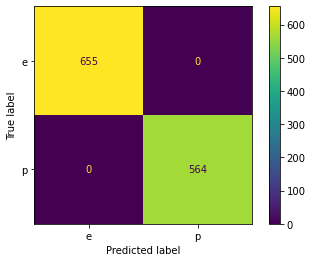

In [73]:
plot_confusion_matrix(model,x_test,y_test)

In [74]:
accuracy_score(y_test,preds)

1.0

In [75]:
feat = model.feature_importances_
feat

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.05555556, 0.05555556, 0.05555556,
       0.        , 0.        , 0.11111111, 0.05555556, 0.        ,
       0.        , 0.        , 0.        , 0.16666667, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.05555556, 0.        , 0.        , 0.        , 0.        ,
       0.05555556, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.05555556, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [76]:
feature_importance_df = pd.DataFrame(index=x.columns, data=feat,columns=['feature_importance']).reset_index()

In [77]:
feature_importance_df

,index,feature_importance
0,cap-shape_c,0.0
1,cap-shape_f,0.0
2,cap-shape_k,0.0
3,cap-shape_s,0.0
4,cap-shape_x,0.0
...,...,...
90,habitat_l,0.0
91,habitat_m,0.0
92,habitat_p,0.0
93,habitat_u,0.0


In [78]:
most_important_df =feature_importance_df[feature_importance_df['feature_importance']>0.00].sort_values('feature_importance') 
most_important_df

,index,feature_importance
17,bruises_t,0.055556
18,odor_c,0.055556
19,odor_f,0.055556
23,odor_p,0.055556
45,stalk-surface-above-ring_k,0.055556
50,stalk-surface-below-ring_y,0.055556
62,stalk-color-below-ring_n,0.055556
80,spore-print-color_r,0.055556
84,population_c,0.055556
22,odor_n,0.111111


<AxesSubplot:xlabel='feature_importance', ylabel='index'>

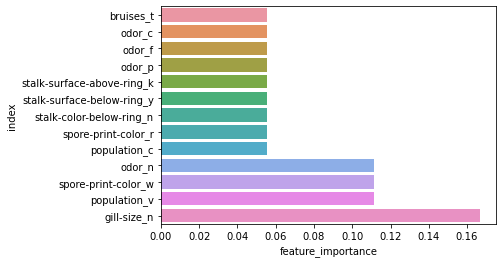

In [79]:
sns.barplot(data=most_important_df,x='feature_importance',y='index')

# Gradient Boosting

In [82]:
gb_model = GradientBoostingClassifier()

In [91]:
param_grid ={
    'n_estimators':[50,100],
    'learning_rate':[0.1,0.05,.2],
    'max_depth':[3,4,5]
}

In [92]:
model = GridSearchCV(estimator=gb_model,param_grid=param_grid)

In [93]:
model.fit(x_train,y_train)


GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1, 0.05, 0.2],
                         'max_depth': [3, 4, 5], 'n_estimators': [50, 100]})

In [94]:
preds = model.predict(x_test)

In [95]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           e       1.00      1.00      1.00       655
           p       1.00      1.00      1.00       564

    accuracy                           1.00      1219
   macro avg       1.00      1.00      1.00      1219
weighted avg       1.00      1.00      1.00      1219



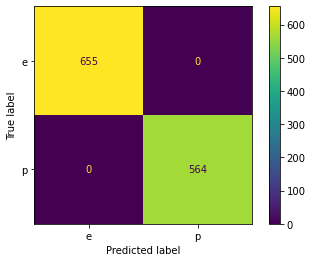

In [96]:
plot_confusion_matrix(model,x_test,y_test)

In [97]:
model.best_estimator_

GradientBoostingClassifier()

In [98]:
model.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

In [99]:
accuracy_score(y_test,preds)

1.0

In [102]:
feat = model.best_estimator_.feature_importances_
feat

array([2.91150176e-04, 1.16547489e-16, 1.71137778e-17, 0.00000000e+00,
       8.99185330e-17, 1.04652037e-03, 8.11828057e-19, 3.78276239e-06,
       0.00000000e+00, 3.87213128e-18, 0.00000000e+00, 0.00000000e+00,
       2.02951849e-17, 1.56134326e-21, 0.00000000e+00, 2.22085607e-08,
       2.31055039e-03, 5.15258796e-02, 6.24175887e-04, 2.11705139e-02,
       1.82499853e-02, 3.90526005e-05, 6.14762854e-01, 3.94907433e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.25092906e-02,
       1.03950811e-02, 0.00000000e+00, 1.23587911e-16, 0.00000000e+00,
       1.24463241e-17, 0.00000000e+00, 0.00000000e+00, 3.54442528e-17,
       1.24936058e-16, 0.00000000e+00, 3.68054389e-17, 0.00000000e+00,
       2.03408198e-04, 6.04383631e-05, 1.35971508e-01, 4.69032068e-03,
       2.02878240e-02, 4.64723214e-04, 2.54703069e-03, 4.95063766e-06,
       1.83319493e-05, 1.06382229e-03, 4.78969128e-02, 2.94314156e-04,
       0.00000000e+00, 0.00000000e+00, 4.59787330e-06, 0.00000000e+00,
      

In [103]:
feature_importance_df = pd.DataFrame(index=x.columns, data=feat,columns=['feature_importance']).reset_index()

In [104]:
feature_importance_df

,index,feature_importance
0,cap-shape_c,2.911502e-04
1,cap-shape_f,1.165475e-16
2,cap-shape_k,1.711378e-17
3,cap-shape_s,0.000000e+00
4,cap-shape_x,8.991853e-17
...,...,...
90,habitat_l,0.000000e+00
91,habitat_m,1.471577e-16
92,habitat_p,0.000000e+00
93,habitat_u,1.004851e-05


In [107]:
most_important_df =feature_importance_df[feature_importance_df['feature_importance']>0.0005].sort_values('feature_importance') 
most_important_df

,index,feature_importance
88,population_y,0.000554
18,odor_c,0.000624
71,ring-number_t,0.000676
87,population_v,0.000719
75,ring-type_p,0.000748
70,ring-number_o,0.000997
5,cap-surface_g,0.001047
49,stalk-surface-below-ring_s,0.001064
84,population_c,0.001177
59,stalk-color-below-ring_c,0.001210


<AxesSubplot:xlabel='feature_importance', ylabel='index'>

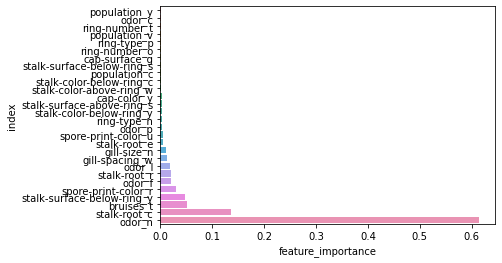

In [108]:
sns.barplot(data=most_important_df,x='feature_importance',y='index')